In [2]:
library(data.table)
library(glmnet)
library(ggplot2)
library(lubridate, quietly=TRUE)
library(zoo, quietly = TRUE)
library(dplyr, quietly = TRUE)
library(GGally, quietly=TRUE)
library(caTools)
library(rpart)
library(rattle)
library(caret)
library(e1071)
library(randomForest)
library(gbm)
library(fastDummies)

### Performance Function

In [2]:
perf_dt=function(type,actual,forecast){
    name=type
    n=length(actual)
    error=actual-forecast
    mean=mean(actual)
    sd=sd(actual)
    FBias=sum(error)/sum(actual)
    MPE=sum(error/actual)/n
    MAPE=sum(abs(error/actual))/n
    RMSE=sqrt(sum(error^2))/n
    MAD=sum(abs(error))/n
    WMAPE=MAD/mean
    l=data.frame(name,n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE)
    return(l)
}

In order to obtain the similar measure performance, a perf_dt function is written. In addition, if target variable categorical, confusionMatrix() function will be used for understanding performance of the model.

# Pisa Dataset

Reading Test Scores
The Programme for International Student Assessment (PISA) is a test given every three years to 15-year-old students from around the world to evaluate their performance in mathematics, reading, and science. This test provides a quantitative way to compare the performance of students from different parts of the world. In this homework assignment, we will predict the reading scores of students from the United States of America on the 2009 PISA exam.

The datasets pisa2009train.csv and pisa2009test.csv contain information about the demographics and schools for American students taking the exam, derived from 2009 PISA Public-Use Data Files distributed by the United States National Center for Education Statistics (NCES). While the datasets are not supposed to contain identifying information about students taking the test, by using the data you are bound by the NCES data use agreement, which prohibits any attempt to determine the identity of any student in the datasets.

Each row in the datasets pisa2009train.csv and pisa2009test.csv represents one student taking the exam. The datasets have the following variables:

grade: The grade in school of the student (most 15-year-olds in America are in 10th grade)

male: Whether the student is male (1/0)

raceeth: The race/ethnicity composite of the student

preschool: Whether the student attended preschool (1/0)

expectBachelors: Whether the student expects to obtain a bachelor's degree (1/0)

motherHS: Whether the student's mother completed high school (1/0)

motherBachelors: Whether the student's mother obtained a bachelor's degree (1/0)

motherWork: Whether the student's mother has part-time or full-time work (1/0)

fatherHS: Whether the student's father completed high school (1/0)

fatherBachelors: Whether the student's father obtained a bachelor's degree (1/0)

fatherWork: Whether the student's father has part-time or full-time work (1/0)

selfBornUS: Whether the student was born in the United States of America (1/0)

motherBornUS: Whether the student's mother was born in the United States of America (1/0)

fatherBornUS: Whether the student's father was born in the United States of America (1/0)

englishAtHome: Whether the student speaks English at home (1/0)

computerForSchoolwork: Whether the student has access to a computer for schoolwork (1/0)

read30MinsADay: Whether the student reads for pleasure for 30 minutes/day (1/0)

minutesPerWeekEnglish: The number of minutes per week the student spend in English class

studentsInEnglish: The number of students in this student's English class at school

schoolHasLibrary: Whether this student's school has a library (1/0)

publicSchool: Whether this student attends a public school (1/0)

urban: Whether this student's school is in an urban area (1/0)

schoolSize: The number of students in this student's school

readingScore: The student's reading score, on a 1000-point scale

### Loading Dataset

In [3]:
pisa_train=read.csv("pisa_train.csv")
pisa_test=read.csv("pisa_test.csv")
pisa_train=as.data.table(pisa_train,na.rm=TRUE)
pisa_test=as.data.table(pisa_test,na.rm=TRUE)
pisa_train=na.omit(pisa_train)
pisa_test=na.omit(pisa_test)

In [4]:
pisa_train$raceeth=as.factor(as.numeric(pisa_train$raceeth))
pisa_test$raceeth=as.factor(as.numeric(pisa_test$raceeth))

In this dataset, train and test dataset were seperated. 23 features exist in the data. Train input size is 2414 and test input size is 990. Namely, both of them exceeds the lower bound(200). In addition, target variable is "readingScore". readingScores take values in between 0 to 1000, which makes the dataset labeled. 

This dataset is proper for **Linear Regression** problems. Much as there is some wheter or not question, these values will be used as numeric. The **only factorial** feature is the **raceeth** representing the race of the students.

In [5]:
str(pisa_train)

Classes 'data.table' and 'data.frame':	2414 obs. of  24 variables:
 $ grade                : int  11 10 10 10 10 10 10 10 11 9 ...
 $ male                 : int  1 0 1 0 1 0 0 0 1 1 ...
 $ raceeth              : Factor w/ 7 levels "1","2","3","4",..: 7 3 4 7 5 4 7 4 7 7 ...
 $ preschool            : int  0 1 1 1 1 1 1 1 1 1 ...
 $ expectBachelors      : int  0 1 0 1 1 1 1 0 1 1 ...
 $ motherHS             : int  1 0 1 1 1 1 1 0 1 1 ...
 $ motherBachelors      : int  1 0 0 0 1 0 0 0 0 1 ...
 $ motherWork           : int  1 1 1 0 1 1 1 0 0 1 ...
 $ fatherHS             : int  1 1 1 1 0 1 1 0 1 1 ...
 $ fatherBachelors      : int  0 0 0 0 0 0 1 0 1 1 ...
 $ fatherWork           : int  1 1 0 1 1 0 1 1 1 1 ...
 $ selfBornUS           : int  1 1 1 1 1 0 1 0 1 1 ...
 $ motherBornUS         : int  1 1 1 1 1 0 1 0 1 1 ...
 $ fatherBornUS         : int  1 1 0 1 1 0 1 0 1 1 ...
 $ englishAtHome        : int  1 1 1 1 1 0 1 0 1 1 ...
 $ computerForSchoolwork: int  1 1 1 1 1 0 1 1 1 1 ...
 $ read30M

In [6]:
str(pisa_test)

Classes 'data.table' and 'data.frame':	990 obs. of  24 variables:
 $ grade                : int  10 10 10 10 11 10 10 10 10 10 ...
 $ male                 : int  0 0 0 0 0 1 0 1 1 0 ...
 $ raceeth              : Factor w/ 7 levels "1","2","3","4",..: 7 7 1 7 7 4 7 4 7 4 ...
 $ preschool            : int  1 1 1 1 0 1 0 1 1 1 ...
 $ expectBachelors      : int  0 1 0 0 0 1 1 0 1 1 ...
 $ motherHS             : int  1 1 1 1 1 1 1 1 1 1 ...
 $ motherBachelors      : int  1 0 0 0 1 1 0 0 1 0 ...
 $ motherWork           : int  1 0 0 1 1 1 0 1 1 1 ...
 $ fatherHS             : int  1 1 1 1 1 1 1 1 1 1 ...
 $ fatherBachelors      : int  0 1 0 0 1 0 0 0 1 1 ...
 $ fatherWork           : int  0 1 0 1 1 1 1 0 1 1 ...
 $ selfBornUS           : int  1 1 1 1 1 1 1 1 1 1 ...
 $ motherBornUS         : int  1 1 1 1 1 1 1 1 1 1 ...
 $ fatherBornUS         : int  1 1 1 1 1 1 1 1 1 1 ...
 $ englishAtHome        : int  1 1 1 1 1 1 1 1 1 1 ...
 $ computerForSchoolwork: int  1 1 1 1 1 1 1 1 1 1 ...
 $ read30M

# Penalized Regression Approaches(PRA)

### L1 Penalty with Mean Square Error measure

In order to tune lambda values, glmnet packages are used to get best lambda values for Penalized Regression. 

In [7]:
train_mat_pisa=data.matrix(pisa_train[complete.cases(pisa_train),-c("readingScore"),with=F])

result_vec_pisa=as.vector(t(pisa_train[complete.cases(pisa_train),"readingScore"]))

cvfit_pisa=cv.glmnet(train_mat_pisa,result_vec_pisa,family="gaussian",nfolds = 10,type.measure = "mse")

test_mat_pisa=data.matrix(pisa_test[complete.cases(pisa_test),-c("readingScore")])

lasso_model_pisa_mse_min <- glmnet(train_mat_pisa,result_vec_pisa, alpha = 1, lambda = cvfit_pisa$lambda.min, standardize = FALSE)
lasso_model_pisa_mse_1se <- glmnet(train_mat_pisa,result_vec_pisa, alpha = 1, lambda = cvfit_pisa$lambda.1se, standardize = FALSE)
lasso_model_pisa_mse_10th <- glmnet(train_mat_pisa,result_vec_pisa, alpha = 1, lambda = cvfit_pisa$lambda[10], standardize = FALSE)

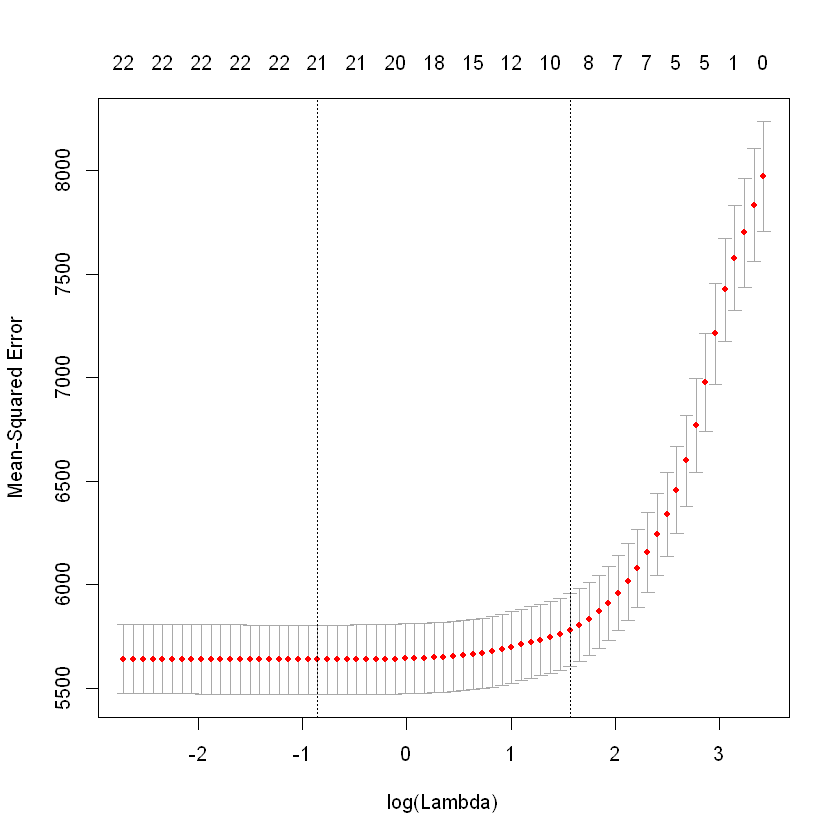

In [8]:
plot(cvfit_pisa)

### Lambda Values for Mean Square Error Values

In [9]:
cvfit_pisa$lambda.min

[1] 0.425836

In [10]:
cvfit_pisa$lambda.1se

[1] 4.783518

In [11]:
cvfit_pisa$lambda[10]

[1] 13.31042

3 possible lambda values are determined by the cv.glmnet(). One of them is used for getting minimum Mean-Squared Error. The other one is determined by looking how many paramater is used in the model. Namely, this lambda value can be beneficial for reducing the possibility of over-fitting model on train dataset. Lastly, one random lambda was selected to compare results for these 3 lambda values.

In [12]:
prediction_pra_mse_pisa_min <- predict(lasso_model_pisa_mse_min, s = cvfit_pisa$lambda.min, newx = test_mat_pisa)
prediction_pra_mse_pisa_1se <- predict(lasso_model_pisa_mse_1se, s = cvfit_pisa$lambda.1se, newx = test_mat_pisa)
prediction_pra_mse_pisa_10th <- predict(lasso_model_pisa_mse_10th, s = cvfit_pisa$lambda[10], newx = test_mat_pisa)

## L1 Penalty with Mean Absolute Error measure

In [13]:
train_mat_pisa=data.matrix(pisa_train[complete.cases(pisa_train),-c("readingScore"),with=F])

result_vec_pisa=as.vector(t(pisa_train[complete.cases(pisa_train),"readingScore"]))

cvfit_pisa_mae=cv.glmnet(train_mat_pisa,result_vec_pisa,family="gaussian",nfolds = 10,type.measure="mae")

test_mat_pisa=data.matrix(pisa_test[complete.cases(pisa_test),-c("readingScore")])

lasso_model_pisa_mae_min <- glmnet(train_mat_pisa,result_vec_pisa, alpha = 1, lambda = cvfit_pisa_mae$lambda.min, standardize = FALSE)
lasso_model_pisa_mae_1se <- glmnet(train_mat_pisa,result_vec_pisa, alpha = 1, lambda = cvfit_pisa_mae$lambda.1se, standardize = FALSE)
lasso_model_pisa_mae_10th <- glmnet(train_mat_pisa,result_vec_pisa, alpha = 1, lambda = cvfit_pisa_mae$lambda[10], standardize = FALSE)

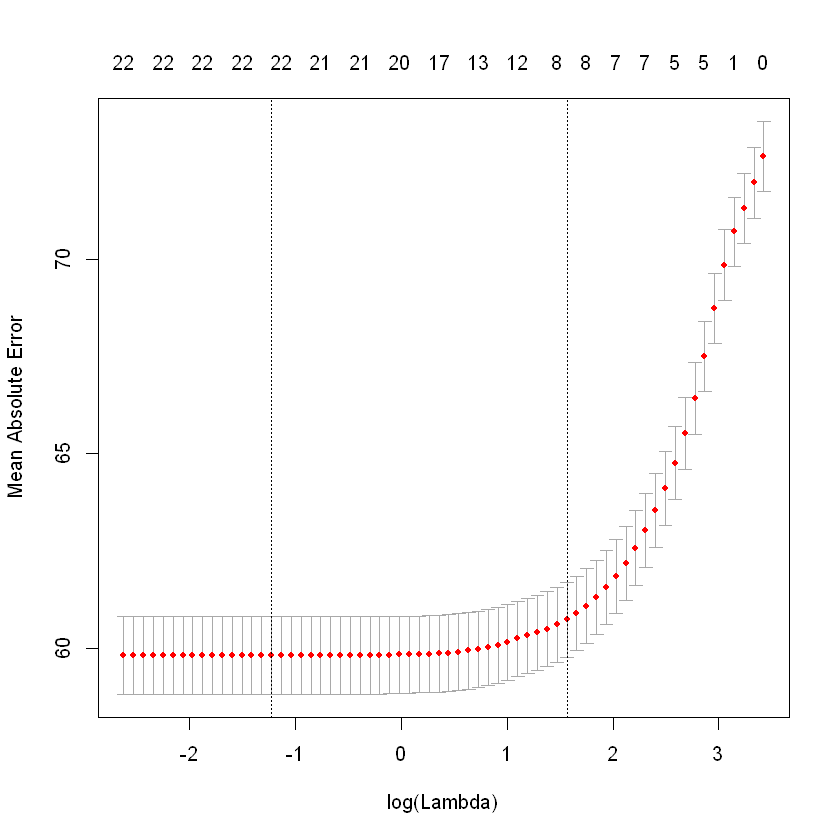

In [14]:
plot(cvfit_pisa_mae)

### Lambda Values for Mean Absolute Error Values

In [15]:
cvfit_pisa_mae$lambda.min

[1] 0.2935122

In [16]:
cvfit_pisa_mae$lambda.1se

[1] 4.783518

In [17]:
cvfit_pisa_mae$lambda[10]

[1] 13.31042

3 possible lambda values are determined by the cv.glmnet(). One of them is used for getting minimum Mean-Squared Error. The other one is determined by looking how many paramater is used in the model. Namely, this lambda value can be beneficial for reducing the possibility of over-fitting model on train dataset. Lastly, one random lambda was selected to compare results for these 3 lambda values.

In [18]:
prediction_pra_mae_pisa_min <- predict(lasso_model_pisa_mae_min, s = cvfit_pisa_mae$lambda.min, newx = test_mat_pisa)
prediction_pra_mae_pisa_1se <- predict(lasso_model_pisa_mae_1se, s = cvfit_pisa_mae$lambda.1se, newx = test_mat_pisa)
prediction_pra_mae_pisa_10th <- predict(lasso_model_pisa_mae_10th, s = cvfit_pisa_mae$lambda[10], newx = test_mat_pisa)

### Performance Measure for Lasso Regression

In [19]:
perf_dt("Pisa Data Set for Lasso Function with min lambda and mse objective", as.numeric(pisa_test$readingScore), prediction_pra_mse_pisa_min)
perf_dt("Pisa Data Set for Lasso Function with 1se lambda and mse objective", as.numeric(pisa_test$readingScore), prediction_pra_mse_pisa_1se)
perf_dt("Pisa Data Set for Lasso Function with 10th lambda and mse objective", as.numeric(pisa_test$readingScore), prediction_pra_mse_pisa_10th)

perf_dt("Pisa Data Set for Lasso Function with min lambda and mae objective", as.numeric(pisa_test$readingScore), prediction_pra_mae_pisa_min)
perf_dt("Pisa Data Set for Lasso Function with 1se lambda and mae objective", as.numeric(pisa_test$readingScore), prediction_pra_mae_pisa_1se)
perf_dt("Pisa Data Set for Lasso Function with 10th lambda and mae objective", as.numeric(pisa_test$readingScore), prediction_pra_mae_pisa_10th)

name,n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE
Pisa Data Set for Lasso Function with min lambda and mse objective,990,519.8643,88.80043,0.007031004,0.1220864,2.435895,60.65549,0.1166756


name,n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE
Pisa Data Set for Lasso Function with 1se lambda and mse objective,990,519.8643,88.80043,0.005745756,0.1260195,2.495768,62.26346,0.1197687


name,n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE
Pisa Data Set for Lasso Function with 10th lambda and mse objective,990,519.8643,88.80043,0.00334385,0.1397751,2.733464,68.49831,0.1317619


name,n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE
Pisa Data Set for Lasso Function with min lambda and mae objective,990,519.8643,88.80043,0.007077976,0.122128,2.437318,60.69028,0.1167425


name,n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE
Pisa Data Set for Lasso Function with 1se lambda and mae objective,990,519.8643,88.80043,0.005745756,0.1260195,2.495768,62.26346,0.1197687


name,n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE
Pisa Data Set for Lasso Function with 10th lambda and mae objective,990,519.8643,88.80043,0.00334385,0.1397751,2.733464,68.49831,0.1317619


### Glmnet with Caret Library

In [20]:
fitControl=trainControl(method = "repeatedcv",
                           number = 10) 

In order to compare obtained result with resamples function, the same process will be made with caret() library. 

In [21]:
lambda_grid <- expand.grid(alpha = 1, lambda = c(cvfit_pisa_mae$lambda.min,
                                                 cvfit_pisa_mae$lambda.1se,
                                                 cvfit_pisa_mae$lambda[10]))

In [23]:
lm_model <- train(readingScore ~ ., data = pisa_train, method = "glmnet", 
                   trControl = fitControl, tuneGrid = lambda_grid)

glmnet 

2414 samples
  23 predictor

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 1 times) 
Summary of sample sizes: 2172, 2170, 2173, 2173, 2172, 2173, ... 
Resampling results across tuning parameters:

  lambda      RMSE      Rsquared   MAE     
   0.2935122  74.18294  0.3113987  59.11383
   4.7835176  75.29688  0.3020824  60.35636
  13.3104220  80.12992  0.2660190  64.68339

Tuning parameter 'alpha' was held constant at a value of 1
RMSE was used to select the optimal model using the smallest value.
The final values used for the model were alpha = 1 and lambda = 0.2935122.

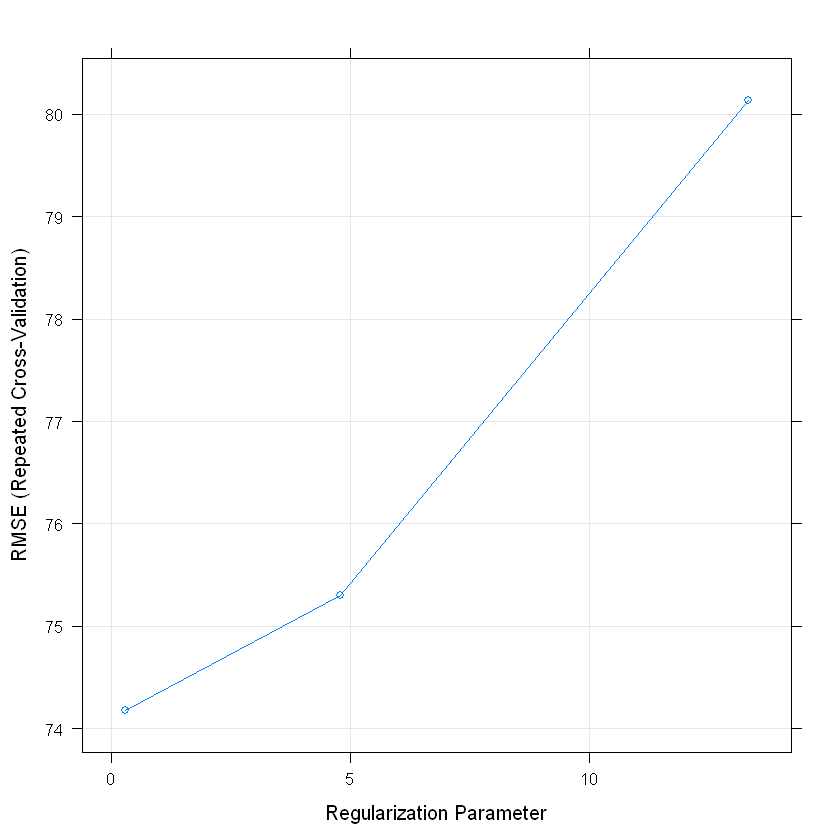

In [24]:
lm_model
plot(lm_model)

# Decision Tree(DT)

In [25]:
set.seed(35)

In [26]:
pisa_train_dt=cbind(pisa_train,dummy_cols(pisa_train$raceeth)[2:8])
pisa_test_dt=cbind(pisa_test,dummy_cols(pisa_test$raceeth)[2:8])
pisa_train_dt[,raceeth:=NULL]
pisa_test_dt[,raceeth:=NULL]

CART 

2414 samples
  29 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 2174, 2174, 2173, 2173, 2172, 2172, ... 
Resampling results across tuning parameters:

  cp    RMSE      Rsquared   MAE     
  0.00  86.43239  0.1788168  69.03796
  0.01  79.78645  0.2062530  63.87710
  0.02  81.55944  0.1706490  65.42246
  0.03  81.84562  0.1643843  65.79221
  0.04  81.84562  0.1643843  65.79221
  0.05  81.84562  0.1643843  65.79221
  0.06  83.80662  0.1249895  67.72905
  0.07  83.83896  0.1239966  67.75617
  0.08  83.83896  0.1239966  67.75617
  0.09  83.83896  0.1239966  67.75617
  0.10  83.83896  0.1239966  67.75617

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was cp = 0.01.
CART 

2414 samples
  29 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 2171, 2172, 2172, 2173, 2171, 2174, ... 
Resampling results across tuning parameters:

  cp    RMSE   

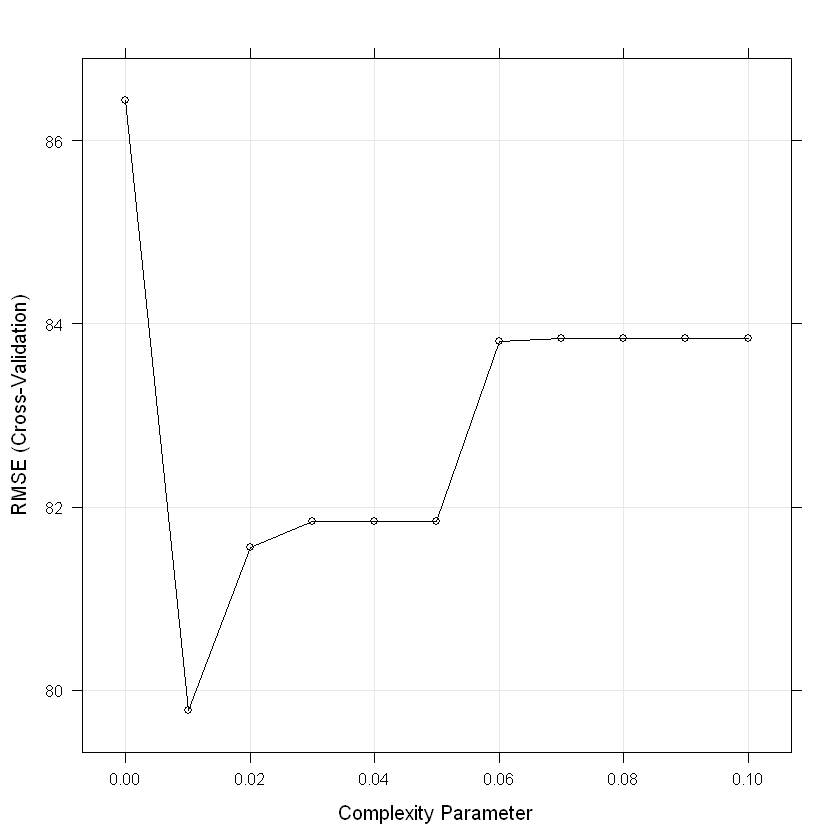

CART 

2414 samples
  29 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 2172, 2173, 2174, 2171, 2172, 2172, ... 
Resampling results across tuning parameters:

  cp    RMSE      Rsquared   MAE     
  0.00  83.19228  0.2057427  66.08406
  0.01  79.54630  0.2087188  63.63208
  0.02  81.23162  0.1744081  64.94994
  0.03  81.73480  0.1635318  65.72892
  0.04  81.73480  0.1635318  65.72892
  0.05  81.73480  0.1635318  65.72892
  0.06  83.80335  0.1219118  67.72705
  0.07  83.80335  0.1219118  67.72705
  0.08  83.80335  0.1219118  67.72705
  0.09  83.80335  0.1219118  67.72705
  0.10  83.80335  0.1219118  67.72705

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was cp = 0.01.


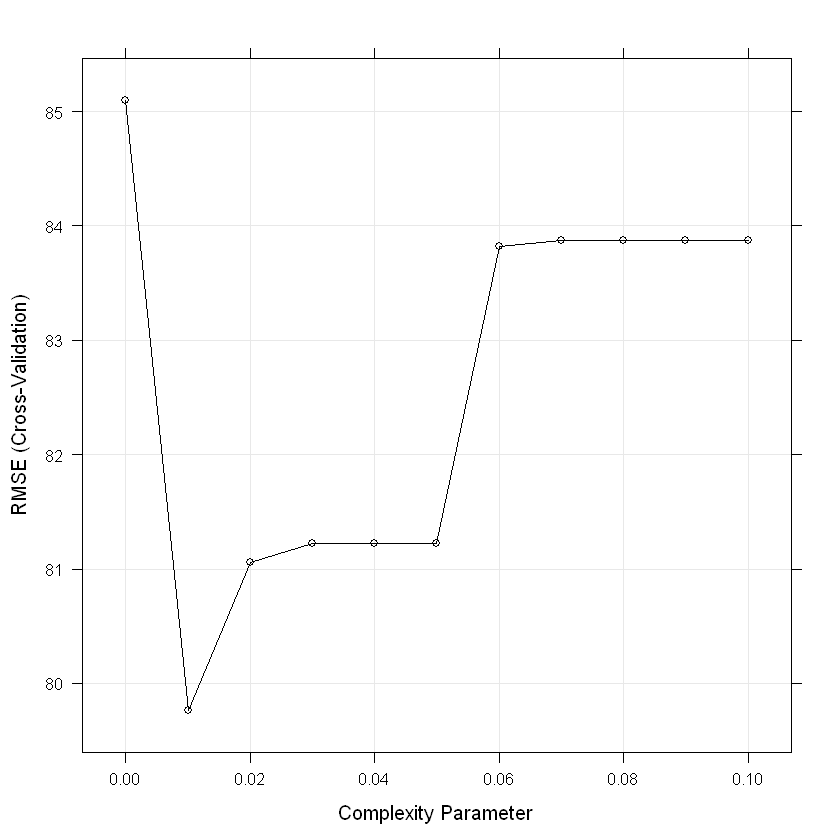

CART 

2414 samples
  29 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 2173, 2172, 2171, 2172, 2174, 2173, ... 
Resampling results across tuning parameters:

  cp    RMSE      Rsquared   MAE     
  0.00  82.74390  0.2064050  65.99749
  0.01  79.94185  0.2039930  64.28358
  0.02  81.30953  0.1749238  65.28039
  0.03  81.21586  0.1759162  65.34955
  0.04  81.21586  0.1759162  65.34955
  0.05  81.21586  0.1759162  65.34955
  0.06  83.78658  0.1246983  67.72485
  0.07  83.86069  0.1237147  67.75225
  0.08  83.86069  0.1237147  67.75225
  0.09  83.86069  0.1237147  67.75225
  0.10  83.86069  0.1237147  67.75225

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was cp = 0.01.


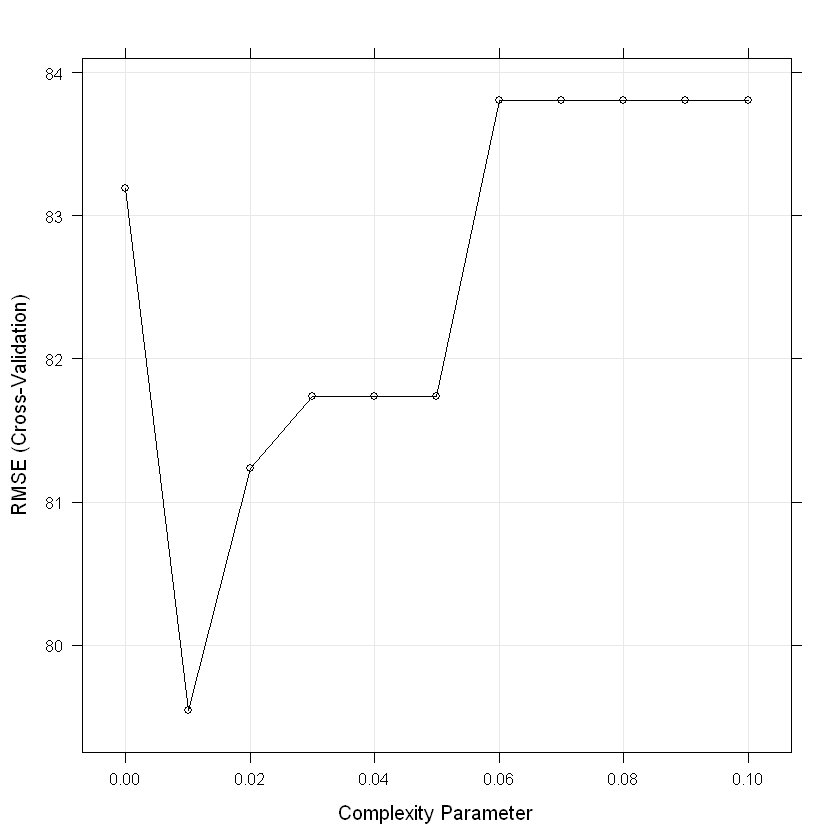

CART 

2414 samples
  29 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 2174, 2174, 2174, 2172, 2173, 2172, ... 
Resampling results across tuning parameters:

  cp    RMSE      Rsquared   MAE     
  0.00  81.09108  0.2224158  64.68187
  0.01  79.62314  0.2078914  63.89771
  0.02  81.23304  0.1745189  65.18371
  0.03  81.17396  0.1752825  65.28091
  0.04  81.17396  0.1752825  65.28091
  0.05  81.17396  0.1752825  65.28091
  0.06  83.83153  0.1203198  67.71387
  0.07  83.83153  0.1203198  67.71387
  0.08  83.83153  0.1203198  67.71387
  0.09  83.83153  0.1203198  67.71387
  0.10  83.83153  0.1203198  67.71387

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was cp = 0.01.


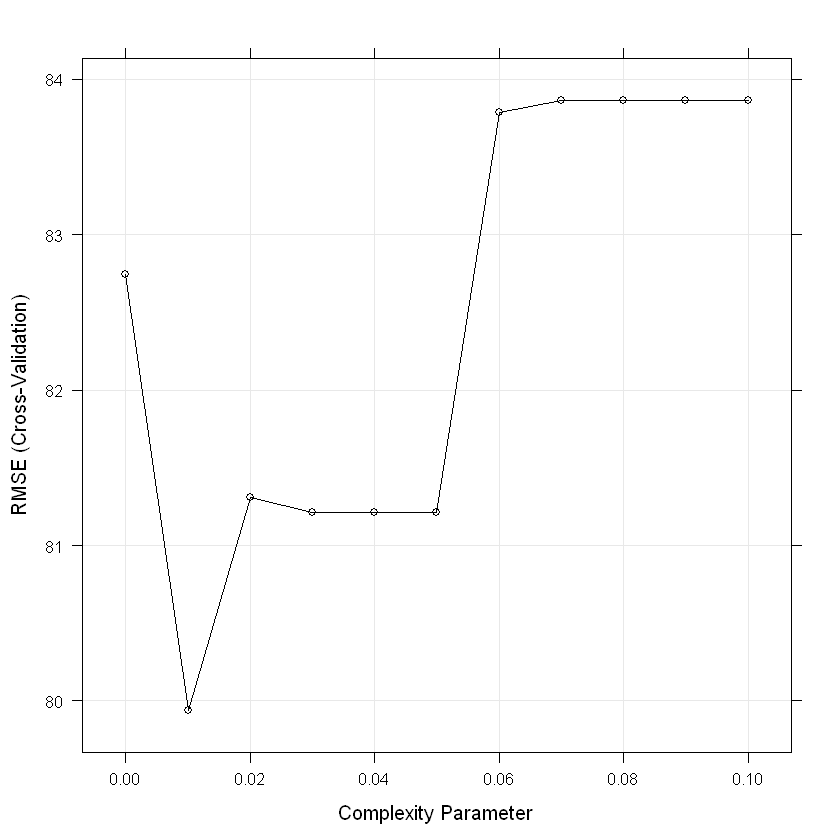

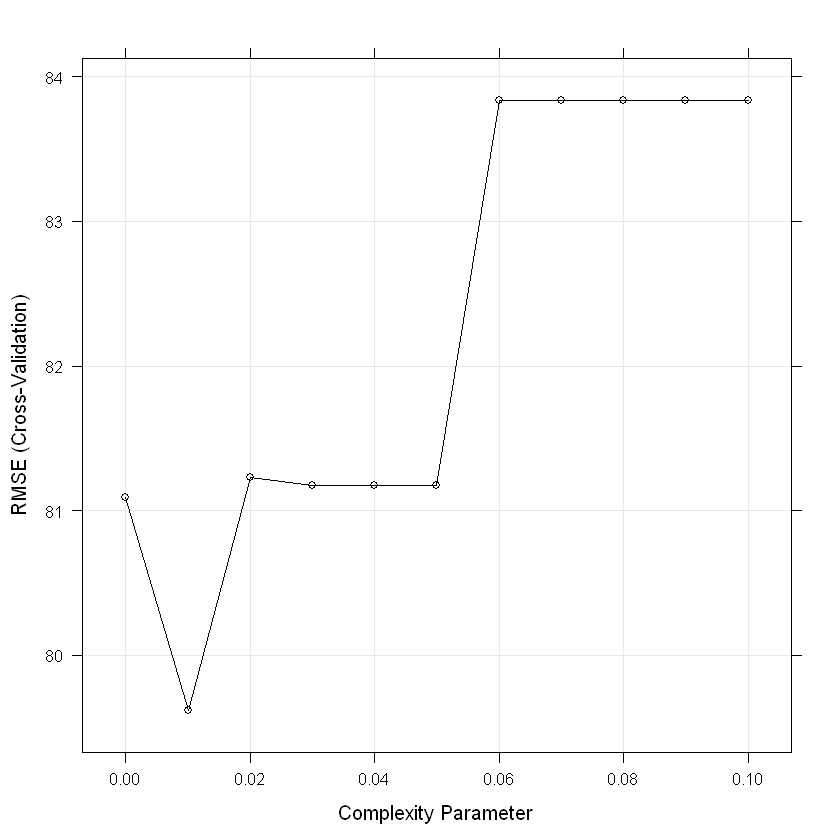

CART 

2414 samples
  29 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 2172, 2174, 2172, 2174, 2172, 2172, ... 
Resampling results across tuning parameters:

  cp    RMSE      Rsquared   MAE     
  0.00  80.30267  0.2296149  63.79635
  0.01  79.13076  0.2179484  63.53133
  0.02  80.98301  0.1805495  65.06587
  0.03  81.17066  0.1758621  65.28910
  0.04  81.17066  0.1758621  65.28910
  0.05  81.17066  0.1758621  65.28910
  0.06  83.84066  0.1207353  67.73345
  0.07  83.84066  0.1207353  67.73345
  0.08  83.84066  0.1207353  67.73345
  0.09  83.84066  0.1207353  67.73345
  0.10  83.84066  0.1207353  67.73345

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was cp = 0.01.


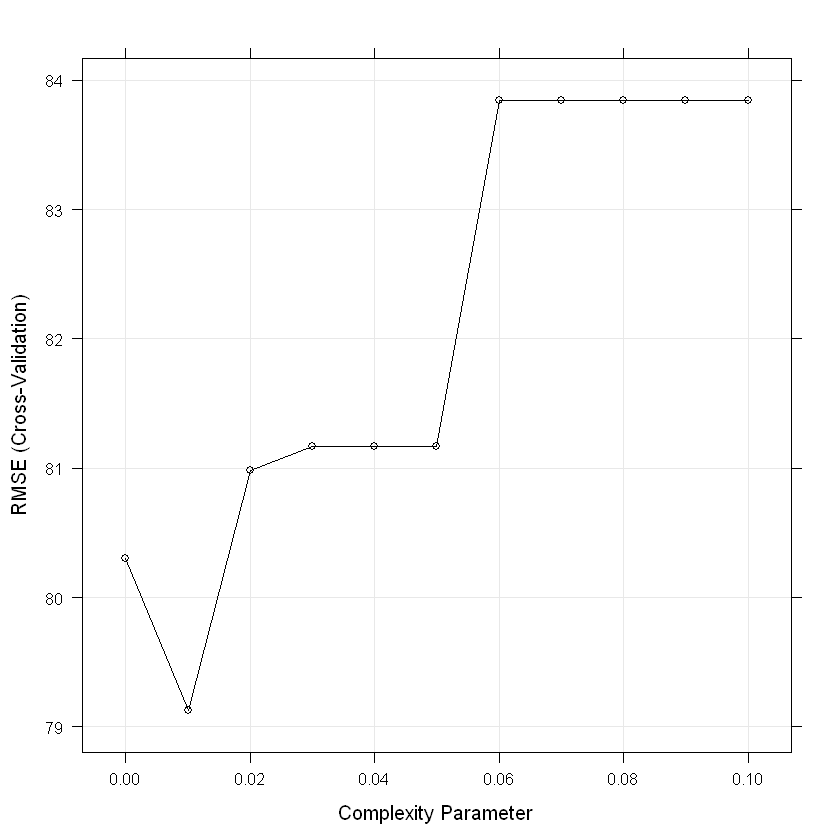

In [84]:
numFolds=trainControl(method="cv",number = 10)
cpGrid=expand.grid(.cp=(0:10)*0.01)
#minbucket_grid=expand.grid(.cp=(5:10))
for(i in 5:10){
    tr=train(readingScore~.,
          data=pisa_train_dt, 
          method="rpart",
          trControl=numFolds,
          tuneGrid= cpGrid,
            # minbucket=minbucket_grid
           control= rpart.control(minbucket = i)
            )
    trellis.par.set(caretTheme())
    print(plot(tr))    
    print(tr)
}

Best minbucket is determined by looking the plots and the RMSE values in the models. The model with smallest RMSE value's minbucket is determined as optimal minbucket size for Decision Tree. This model is names as tr_last to keep information of this model to compare with other models.

CART 

2414 samples
  29 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 2174, 2171, 2173, 2172, 2172, 2172, ... 
Resampling results across tuning parameters:

  cp    RMSE      Rsquared   MAE     
  0.00  80.54359  0.2271929  64.29627
  0.01  79.54121  0.2094880  63.67533
  0.02  81.09784  0.1780498  65.22498
  0.03  81.86471  0.1618356  65.90086
  0.04  81.86471  0.1618356  65.90086
  0.05  81.86471  0.1618356  65.90086
  0.06  83.80165  0.1216110  67.70118
  0.07  83.82850  0.1210650  67.73239
  0.08  83.82850  0.1210650  67.73239
  0.09  83.82850  0.1210650  67.73239
  0.10  83.82850  0.1210650  67.73239

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was cp = 0.01.


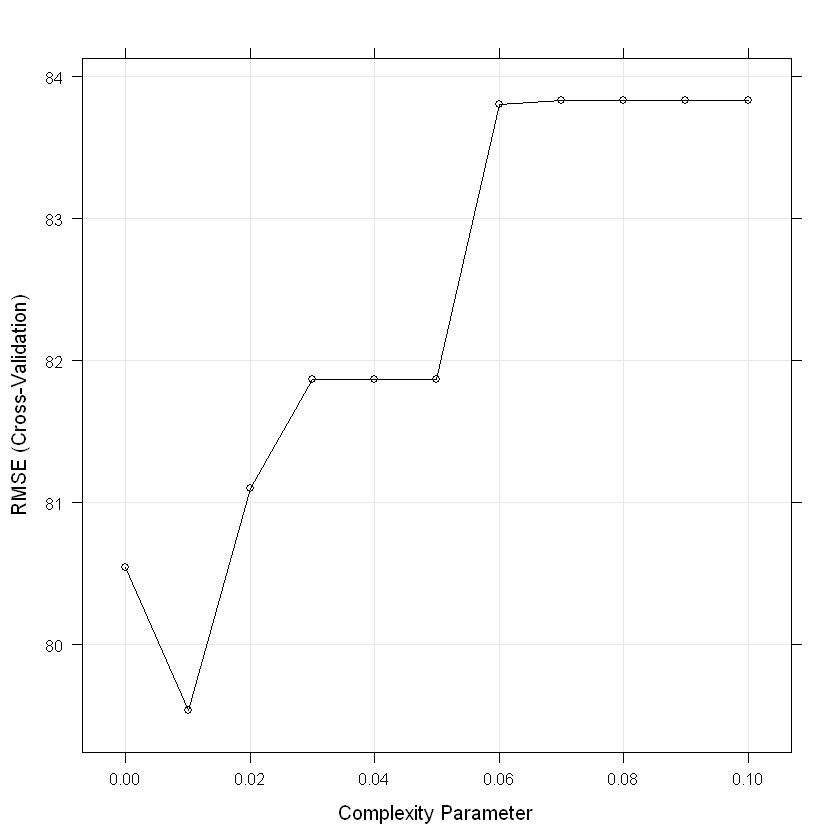

In [91]:
numFolds=trainControl(method="cv",number = 10)
cpGrid=expand.grid(.cp=(0:10)*0.01)
tr_last=train(readingScore~.,
      data=pisa_train_dt, 
      method="rpart",
      trControl=numFolds,
      tuneGrid= cpGrid,
        # minbucket=minbucket_grid
       control= rpart.control(minbucket = 9)
        )
trellis.par.set(caretTheme())
print(plot(tr_last))    
print(tr_last)

expectBachelors               .data_7               .data_4 
         2282409.8932          1070628.9082           542284.6944 
         motherBornUS          fatherBornUS       motherBachelors 
          429366.8017           400091.7925           393018.0663 
                grade               .data_3         englishAtHome 
          293364.1240           269051.2751           257898.8907 
              .data_2       fatherBachelors        read30MinsADay 
          257193.8455           204369.3945           192735.0401 
                 male             preschool          publicSchool 
           43231.9873            41921.9271            34716.5959 
                urban            schoolSize     studentsInEnglish 
           19650.9033            11412.0495             7550.3792 
minutesPerWeekEnglish 
             922.1772

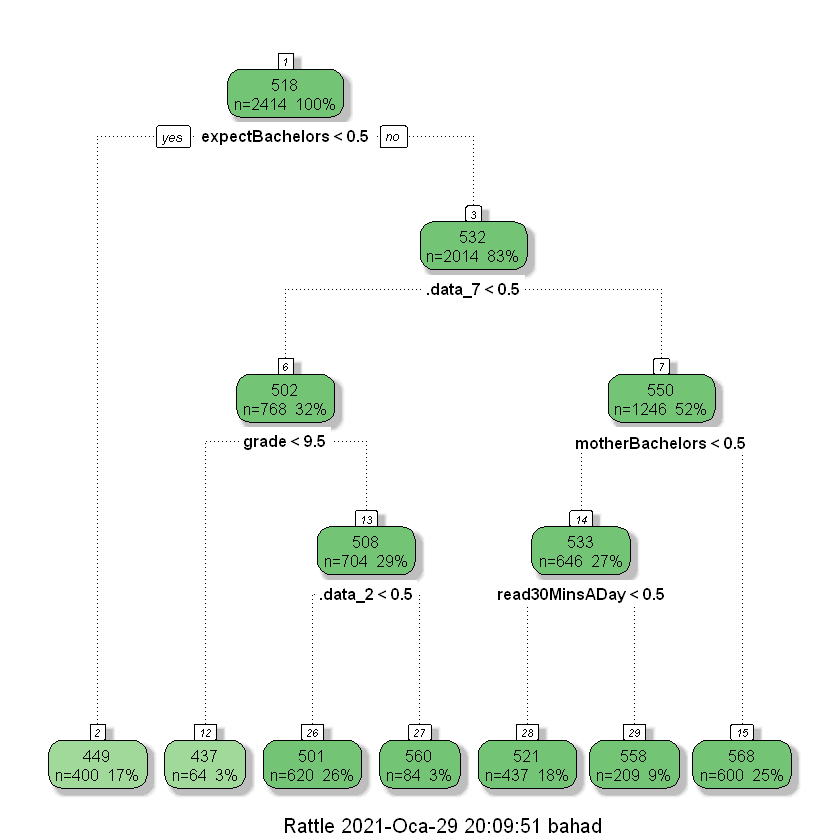

In [87]:
reg_tree_pisa=tr$finalModel
fancyRpartPlot(reg_tree_pisa)
reg_tree_pisa$variable.importance

In [88]:
predicted_pisa_dt=predict(reg_tree_pisa,newdata=pisa_test_dt)

### Performanca Measure

In [89]:
perf_dt("Decision Tree with CV for Pisa Dataset",pisa_test_dt$readingScore,as.numeric(predicted_pisa_dt))

name,n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE
Decision Tree with CV for Pisa Dataset,990,519.8643,88.80043,0.007325851,0.1262667,2.506513,62.69629,0.1206013


## Random Forest(RF)

In [46]:
library(ranger)

In [33]:
fitControl=trainControl(method = "repeatedcv",
                           number = 10) 

In [34]:
rf_grid=expand.grid(mtry=c(4,8,10,15),
                   splitrule = c("variance"),
                   min.node.size= c(5))
rf_grid  

mtry,splitrule,min.node.size
4,variance,5
8,variance,5
10,variance,5
15,variance,5


In [35]:
rf_fit=train(readingScore ~ ., data = pisa_train, 
                 method = "ranger", 
                 trControl = fitControl, num.trees=500,
                 tuneGrid = rf_grid) 

Random Forest 

2414 samples
  23 predictor

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 1 times) 
Summary of sample sizes: 2173, 2172, 2172, 2173, 2173, 2173, ... 
Resampling results across tuning parameters:

  mtry  RMSE      Rsquared   MAE     
   4    74.22778  0.3127169  59.68398
   8    74.86137  0.2988596  60.03758
  10    75.34474  0.2908063  60.46137
  15    75.50474  0.2895483  60.54514

Tuning parameter 'splitrule' was held constant at a value of variance

Tuning parameter 'min.node.size' was held constant at a value of 5
RMSE was used to select the optimal model using the smallest value.
The final values used for the model were mtry = 4, splitrule = variance
 and min.node.size = 5.

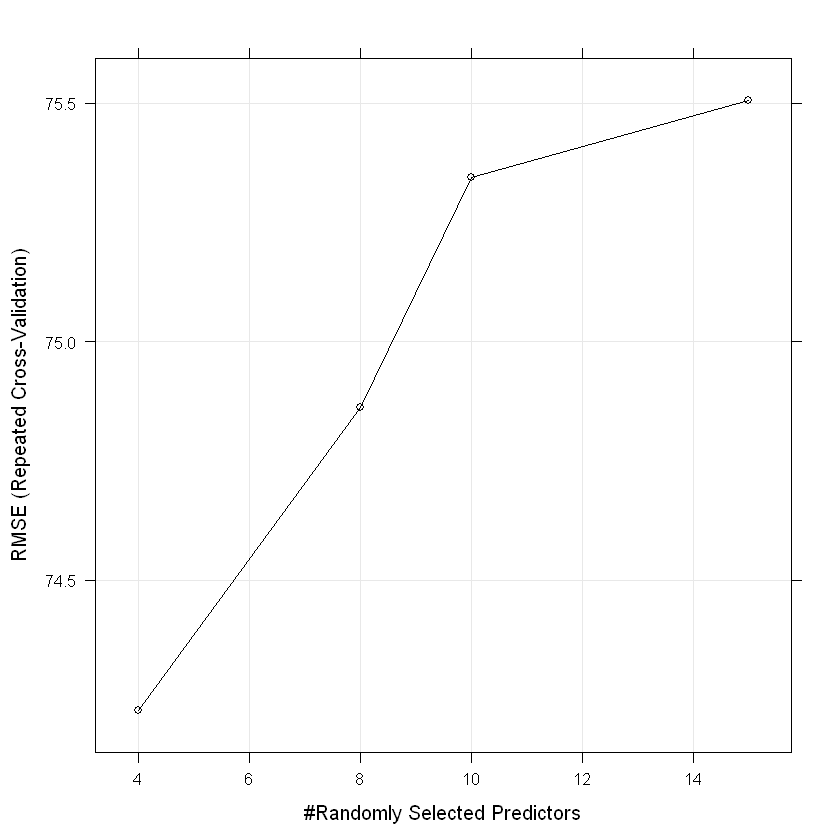

In [36]:
rf_fit
plot(rf_fit)

In [37]:
RandomForest_pisa=predict(rf_fit,newdata=pisa_test)

### Performanca Measure

In [38]:
perf_dt("First Data Set for Random Forest", as.numeric(RandomForest_pisa), as.numeric(pisa_test$readingScore))

name,n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE
First Data Set for Random Forest,990,517.8192,45.48294,-0.003949342,0.1157326,2.383545,59.41911,0.1147487


# Stochastic Gradient Boosting(SGB)

In [39]:
set.seed(35)

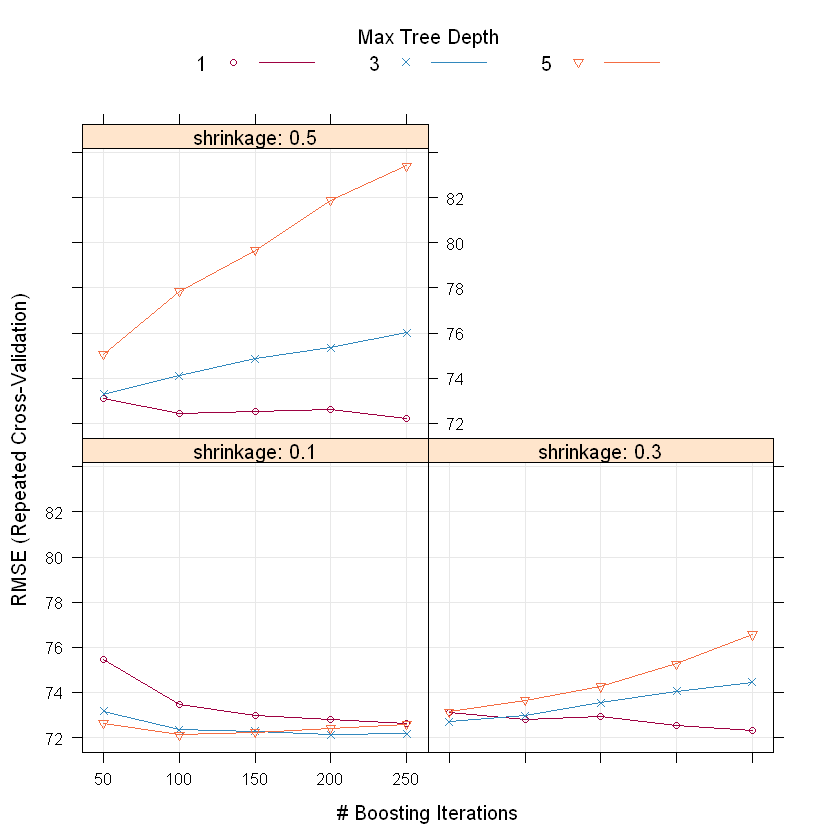

In [40]:
gbmGrid=expand.grid(interaction.depth = c(1, 3, 5), 
                        n.trees = (1:5)*50, 
                        shrinkage = c(0.1, 0.3, 0.5),
                        n.minobsinnode = 20)
                                                                

gbm_fit=train(readingScore ~ ., data = pisa_train, 
                 method = "gbm", 
                 trControl = fitControl,  
                 tuneGrid = gbmGrid,
                 verbose=F) #verbose is an argument from gbm, prints to screen

plot(gbm_fit)

In [41]:
predicted_pisa_sgb=predict(gbm_fit,pisa_test)

### Performanca Measure

In [42]:
perf_dt("First Data Set for Stochastic Gradient Boosting", as.numeric(predicted_pisa_sgb), as.numeric(pisa_test$readingScore))

name,n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE
First Data Set for Stochastic Gradient Boosting,990,516.5296,52.44005,-0.00645595,0.1154572,2.364434,58.9861,0.1141969


# General Result for 4 Method for Pisa Reading Results with Test Dataset

In [43]:
perf_dt("Pisa Data Set for Lasso Function with min lambda and mse objective", as.numeric(pisa_test$readingScore), prediction_pra_mse_pisa_min)
perf_dt("Decision Tree with CV for Pisa Dataset",pisa_test_dt$readingScore,as.numeric(predicted_pisa_dt))
perf_dt("First Data Set for Random Forest", as.numeric(RandomForest_pisa), as.numeric(pisa_test$readingScore))
perf_dt("First Data Set for Stochastic Gradient Boosting", as.numeric(predicted_pisa_sgb), as.numeric(pisa_test$readingScore))

name,n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE
Pisa Data Set for Lasso Function with min lambda and mse objective,990,519.8643,88.80043,0.007031004,0.1220864,2.435895,60.65549,0.1166756


name,n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE
Decision Tree with CV for Pisa Dataset,990,519.8643,88.80043,0.007325851,0.1262667,2.506513,62.69629,0.1206013


name,n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE
First Data Set for Random Forest,990,517.8192,45.48294,-0.003949342,0.1157326,2.383545,59.41911,0.1147487


name,n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE
First Data Set for Stochastic Gradient Boosting,990,516.5296,52.44005,-0.00645595,0.1154572,2.364434,58.9861,0.1141969


# Conclusion of Models

## Linear Regression with Penalty

Different Penalty types are tried in the glmnet package by using mean absolute percentage error and mean square error objective. In these 2 penalty, 3 different lambdas are tried to obtain a model. In addition, all the possible lambda values are checked by plotting the cv.glmnet() results. Predictions are made based on these models. Best model performance are observed in this test dataset. After all, caret() packages are used to make a model can be comparable with other method's models. Namely, caret library is used in all the methods to obtain similar report types. Penalized Regression Approach is made with 3 different lambda values. These are lambda.min, lambda.1se, and random a lambda value achieved in the previous cv.glmnet() process. Model results are as follows:

In [70]:
lm_model

glmnet 

2414 samples
  23 predictor

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 1 times) 
Summary of sample sizes: 2172, 2170, 2173, 2173, 2172, 2173, ... 
Resampling results across tuning parameters:

  lambda      RMSE      Rsquared   MAE     
   0.2935122  74.18294  0.3113987  59.11383
   4.7835176  75.29688  0.3020824  60.35636
  13.3104220  80.12992  0.2660190  64.68339

Tuning parameter 'alpha' was held constant at a value of 1
RMSE was used to select the optimal model using the smallest value.
The final values used for the model were alpha = 1 and lambda = 0.2935122.

### Best Model for Penalized Regression Approach

RMSE will be the objective parameter for evaluation of the model. In this perpective, **lambda 0.2935122(lambda.min) and MAE Penalty type** is the best tuned parameter for this model for Pisa Reading Score Dataset.

In [100]:
print(paste("The Smallest RMSE value in Penalized Regression Approach:",lm_model$results$RMSE[which.min(lm_model$results$RMSE)]))

[1] "The Smallest RMSE value in Penalized Regression Approach: 74.1829393463686"


## Decision Tree

**6 different minbucket** values are tried to get best model for Decision Tree. However, in caret library there is no available packages for rpart for tuning the minimal number of observation per tree leaf. So for loop is tried to get information related to effects in the change of number of variable in the tree leaf. In addition, all models tested with **10 different cp value**. After looking the created model's result, the best model is selected. The best RMSE value is selected with considering the minbucket values and cp values. Selected model evaluated 1 more time and named as tr_last. Model results are as follows:

In [92]:
tr_last

CART 

2414 samples
  29 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 2174, 2171, 2173, 2172, 2172, 2172, ... 
Resampling results across tuning parameters:

  cp    RMSE      Rsquared   MAE     
  0.00  80.54359  0.2271929  64.29627
  0.01  79.54121  0.2094880  63.67533
  0.02  81.09784  0.1780498  65.22498
  0.03  81.86471  0.1618356  65.90086
  0.04  81.86471  0.1618356  65.90086
  0.05  81.86471  0.1618356  65.90086
  0.06  83.80165  0.1216110  67.70118
  0.07  83.82850  0.1210650  67.73239
  0.08  83.82850  0.1210650  67.73239
  0.09  83.82850  0.1210650  67.73239
  0.10  83.82850  0.1210650  67.73239

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was cp = 0.01.

### Best Model for Decision Tree

RMSE will be the objective parameter for evaluation of the model. In this perpective, **cp=0.01 and minbucket = 9** is the best tuned parameter for this model for Pisa Reading Score Dataset.

In [93]:
print(paste("The Smallest RMSE value in Decision Tree:",tr_last$results$RMSE[which.min(tr_last$results$RMSE)]))

[1] 79.54121

## Random Forest

As mentioned in the homework description, only mtry namely number of selected feature for model is modified. 4 different number is determined. Best model is achived the model with the biggest number of feature. Hovewer, Mean Absolute Error is the smallest in the model with the smallest number of feature. Model results are as follows:

In [49]:
rf_fit

Random Forest 

2414 samples
  23 predictor

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 1 times) 
Summary of sample sizes: 2173, 2172, 2172, 2173, 2173, 2173, ... 
Resampling results across tuning parameters:

  mtry  RMSE      Rsquared   MAE     
   4    74.22778  0.3127169  59.68398
   8    74.86137  0.2988596  60.03758
  10    75.34474  0.2908063  60.46137
  15    75.50474  0.2895483  60.54514

Tuning parameter 'splitrule' was held constant at a value of variance

Tuning parameter 'min.node.size' was held constant at a value of 5
RMSE was used to select the optimal model using the smallest value.
The final values used for the model were mtry = 4, splitrule = variance
 and min.node.size = 5.

### Best Model for Random Forest

RMSE will be the objective parameter for evaluation of the model. In this perpective, **mtry=4** is the best tuned parameter for this model for Pisa Reading Score Dataset.

In [99]:
print(paste("The Smallest RMSE value in Random Forest:",rf_fit$results$RMSE[which.min(rf_fit$results$RMSE)]))

[1] "The Smallest RMSE value in Random Forest: 74.2277812566288"


## Stochastic Gradient Boosting

**Different 5 shrinkage value, 3 interaction.depth, 5 n.trees values** are tried to obtain the best model. This model is the one which takes the most time to create the models. The reason behind this fact caused from number of tuned parameter in the approach. However, it has the best RMSE value among the models. Model results are as follows:

In [50]:
gbm_fit

Stochastic Gradient Boosting 

2414 samples
  23 predictor

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 1 times) 
Summary of sample sizes: 2173, 2172, 2172, 2171, 2173, 2174, ... 
Resampling results across tuning parameters:

  shrinkage  interaction.depth  n.trees  RMSE      Rsquared   MAE     
  0.1        1                   50      75.47460  0.3126352  60.62038
  0.1        1                  100      73.47254  0.3300000  58.69375
  0.1        1                  150      72.95822  0.3358354  58.19940
  0.1        1                  200      72.80733  0.3378907  58.00691
  0.1        1                  250      72.63771  0.3407722  57.90860
  0.1        3                   50      73.16656  0.3337547  58.63596
  0.1        3                  100      72.34571  0.3459466  57.79544
  0.1        3                  150      72.28070  0.3472914  57.76970
  0.1        3                  200      72.12923  0.3504537  57.65767
  0.1        3                  250      72

### Best Model for Stochastic Gradient Boosting

RMSE will be the objective parameter for evaluation of the model. In this perpective, **n.trees = 100 interaction.depth =
 5, shrinkage = 0.1 and n.minobsinnode = 20** is the best tuned parameter for this model for Pisa Reading Score Dataset.

In [97]:
print(paste("The Smallest RMSE value in Stochastic Gradient Boosting:",gbm_fit$results$RMSE[which.min(gbm_fit$results$RMSE)]))

[1] "The Smallest RMSE value in Stochastic Gradient Boosting: 72.1221273300718"


# Comparision of Results in Training and Test Dataset

In [126]:
train=list("Linear Regression with Lasso Results"=lm_model$results$RMSE[which.min(lm_model$results$RMSE)],
            "Decision Tree Results"=    tr_last$results$RMSE[which.min(tr_last$results$RMSE)],
            "Random Forest Results"=    rf_fit$results$RMSE[which.min(rf_fit$results$RMSE)],
            "Result Stochastic Gradient Boosting Results"=    gbm_fit$results$RMSE[which.min(gbm_fit$results$RMSE)])

## RMSE in The Train Dataset

In [129]:
t(train)

Linear Regression with Lasso Results,Decision Tree Results,Random Forest Results,Result Stochastic Gradient Boosting Results
74.18294,79.54121,74.22778,72.12213


In [115]:
perf_dt("Pisa Data Set for Lasso Function with min lambda and mse objective", as.numeric(pisa_test$readingScore), prediction_pra_mse_pisa_min)
perf_dt("Decision Tree with CV for Pisa Dataset",pisa_test_dt$readingScore,as.numeric(predicted_pisa_dt))
perf_dt("First Data Set for Random Forest", as.numeric(RandomForest_pisa), as.numeric(pisa_test$readingScore))
perf_dt("First Data Set for Stochastic Gradient Boosting", as.numeric(predicted_pisa_sgb), as.numeric(pisa_test$readingScore))

name,n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE
Pisa Data Set for Lasso Function with min lambda and mse objective,990,519.8643,88.80043,0.007031004,0.1220864,2.435895,60.65549,0.1166756


name,n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE
Decision Tree with CV for Pisa Dataset,990,519.8643,88.80043,0.007325851,0.1262667,2.506513,62.69629,0.1206013


name,n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE
First Data Set for Random Forest,990,517.8192,45.48294,-0.003949342,0.1157326,2.383545,59.41911,0.1147487


name,n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE
First Data Set for Stochastic Gradient Boosting,990,516.5296,52.44005,-0.00645595,0.1154572,2.364434,58.9861,0.1141969


Models got similar performance as achieved in the training dataset. Namely, it is hard to say that there is an over-fitting or under-fitting. Reading Score Estimation can be described as regression problem, so having the worst performance measure both training and test data sets aren't a suprise for decision tree model. In addition to under/over-fitting, it can be said that error rates are consistent for both datasets, which can be observed looking the correlation between the results pf performance of the models in both dataset. 